In [1]:
import tensorflow as tf
from tensorflow import keras 

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

import glob
import os
import numpy as np
from matplotlib import pyplot as plt


Segmentation Models: using `keras` framework.


In [2]:
from keras.utils import conv_utils
from keras.utils.conv_utils import normalize_data_format
keras.backend.set_image_data_format('channels_last')
from keras.metrics import MeanIoU

In [3]:
os.chdir('<your file dir>')

In [6]:
import fnmatch
import os

train_dirpath= '<train_folder>'
print('Number of training images:', len(fnmatch.filter(os.listdir(train_dirpath), '*.tif')))

label_dirpath= '<mask_folder>'
print('Number of label images:', len(fnmatch.filter(os.listdir(label_dirpath), '*.tif')))

Number of training images: 1476
Number of label images: 1476


In [9]:
from PIL import Image
import sys

mask_num=0
train_masks = []
height = 256
width = 256


files = glob.glob(os.path.join(label_dirpath, "*.tif"))
for my_file in files:
    image = Image.open(my_file)
    image = np.array(image)
    if image.shape == (height, width):
        train_masks.append(image)
        mask_num += 1
        sys.stdout.write("\rFile %s was processed." % mask_num)
        sys.stdout.flush()

print('train masks shape:', np.array(train_masks).shape)

File 1476 was processed.train masks shape: (1476, 256, 256)


In [8]:
import tifffile as tfile
import imagecodecs.numcodecs
import matplotlib.pyplot
import numcodecs
import fsspec
import xarray
import zarr

img_num=0
train_img = []
height = 256
width = 256
channel = 4


files = glob.glob(os.path.join(train_dirpath, "*.tif"))
for my_file in files:
    image = tfile.imread(my_file)
    image = np.array(image)
    if image.shape == (height, width, channel):
        train_img.append(image)
        img_num += 1
        sys.stdout.write("\rFile %s was processed." % img_num)
        sys.stdout.flush()

print('train img shape:', np.array(train_img).shape)



File 1476 was processed.train img shape: (1476, 256, 256, 4)


In [10]:
train_images = np.array(train_img)
train_img = np.array(train_images[:, :, :, :3])

train_images = np.array(train_img)
train_masks = np.array(train_masks)
#train_masks = train_masks.astype(np.uint8)
print(train_images.shape)
print(train_masks.shape)

print("Mask min=", train_masks.min())
print("Mask max=", train_masks.max())
print("train image min=", train_images.min())
print("train images max=", train_images.max())## need to normalize values

(1476, 256, 256, 3)
(1476, 256, 256)
Mask min= 0
Mask max= 3
train image min= -10000.0
train images max= 255.0


In [11]:
train_images = np.where(train_images<0, 0, train_images) # to get rid of negative values
train_masks = np.where(train_masks>1, 0, train_masks) # 3 was no data value

train_images_norm = np.divide(train_images, 255)

print("train image min=", train_images_norm.min())
print("train images max=", train_images_norm.max())
print("train images new shape=", train_images_norm.shape)

print("Mask min=", train_masks.min())
print("Mask max=", train_masks.max())

train image min= 0.0
train images max= 1.0
train images new shape= (1476, 256, 256, 3)
Mask min= 0
Mask max= 1


## Model buidling

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images_norm, train_masks, test_size = 0.25, shuffle=False, random_state=42)

y_train = np.where(y_train > 1, 1, y_train)
y_test = np.where(y_test > 1, 1, y_test)

print("Class values in the dataset are ... ", np.unique(y_train))
print("Class values in the dataset are ... ", np.unique(y_test))

Class values in the dataset are ...  [0 1]
Class values in the dataset are ...  [0 1]


In [13]:
from tensorflow.keras.utils import to_categorical

n_classes=2
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print("Class values in the dataset are ... ", np.unique(y_train_cat))

Class values in the dataset are ...  [0. 1.]


In [14]:
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file


activation='sigmoid'
LR = 0.0001
optim = keras.optimizers.Adam(LR)
BACKBONE =  'resnet152' 
preprocess_input = sm.get_preprocessing(BACKBONE)
loss=loss=sm.losses.DiceLoss()
metrics=sm.metrics.FScore()

# preprocess input
X_train= preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [15]:
# define model
new_model = load_model("unet_lk_f1score.h5", compile=False)
new_model.compile(optimizer=optim, loss=loss, metrics=metrics)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", patience = 25, restore_best_weights = True)
new_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_104 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                          

                                                                                                  
 stage1_unit2_bn3 (BatchNormali  (None, None, None,   256        ['stage1_unit2_conv2[0][0]']     
 zation)                        64)                                                               
                                                                                                  
 stage1_unit2_relu3 (Activation  (None, None, None,   0          ['stage1_unit2_bn3[0][0]']       
 )                              64)                                                               
                                                                                                  
 stage1_unit2_conv3 (Conv2D)    (None, None, None,   16384       ['stage1_unit2_relu3[0][0]']     
                                256)                                                              
                                                                                                  
 add_101 (

 zation)                        512)                                                              
                                                                                                  
 stage2_unit2_relu1 (Activation  (None, None, None,   0          ['stage2_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 stage2_unit2_conv1 (Conv2D)    (None, None, None,   65536       ['stage2_unit2_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit2_bn2 (BatchNormali  (None, None, None,   512        ['stage2_unit2_conv1[0][0]']     
 zation)                        128)                                                              
          

 stage2_unit4_conv2 (Conv2D)    (None, None, None,   147456      ['zero_padding2d_112[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit4_bn3 (BatchNormali  (None, None, None,   512        ['stage2_unit4_conv2[0][0]']     
 zation)                        128)                                                              
                                                                                                  
 stage2_unit4_relu3 (Activation  (None, None, None,   0          ['stage2_unit4_bn3[0][0]']       
 )                              128)                                                              
                                                                                                  
 stage2_unit4_conv3 (Conv2D)    (None, None, None,   65536       ['stage2_unit4_relu3[0][0]']     
          

                                                                                                  
 stage2_unit7_relu1 (Activation  (None, None, None,   0          ['stage2_unit7_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 stage2_unit7_conv1 (Conv2D)    (None, None, None,   65536       ['stage2_unit7_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit7_bn2 (BatchNormali  (None, None, None,   512        ['stage2_unit7_conv1[0][0]']     
 zation)                        128)                                                              
                                                                                                  
 stage2_un

                                256)                                                              
                                                                                                  
 stage3_unit1_bn3 (BatchNormali  (None, None, None,   1024       ['stage3_unit1_conv2[0][0]']     
 zation)                        256)                                                              
                                                                                                  
 stage3_unit1_relu3 (Activation  (None, None, None,   0          ['stage3_unit1_bn3[0][0]']       
 )                              256)                                                              
                                                                                                  
 stage3_unit1_conv3 (Conv2D)    (None, None, None,   262144      ['stage3_unit1_relu3[0][0]']     
                                1024)                                                             
          

 stage3_unit4_bn1 (BatchNormali  (None, None, None,   4096       ['add_113[0][0]']                
 zation)                        1024)                                                             
                                                                                                  
 stage3_unit4_relu1 (Activation  (None, None, None,   0          ['stage3_unit4_bn1[0][0]']       
 )                              1024)                                                             
                                                                                                  
 stage3_unit4_conv1 (Conv2D)    (None, None, None,   262144      ['stage3_unit4_relu1[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_unit4_bn2 (BatchNormali  (None, None, None,   1024       ['stage3_unit4_conv1[0][0]']     
 zation)  

                                                                                                  
 stage3_unit6_conv2 (Conv2D)    (None, None, None,   589824      ['zero_padding2d_122[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_unit6_bn3 (BatchNormali  (None, None, None,   1024       ['stage3_unit6_conv2[0][0]']     
 zation)                        256)                                                              
                                                                                                  
 stage3_unit6_relu3 (Activation  (None, None, None,   0          ['stage3_unit6_bn3[0][0]']       
 )                              256)                                                              
                                                                                                  
 stage3_un

 zation)                        1024)                                                             
                                                                                                  
 stage3_unit9_relu1 (Activation  (None, None, None,   0          ['stage3_unit9_bn1[0][0]']       
 )                              1024)                                                             
                                                                                                  
 stage3_unit9_conv1 (Conv2D)    (None, None, None,   262144      ['stage3_unit9_relu1[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_unit9_bn2 (BatchNormali  (None, None, None,   1024       ['stage3_unit9_conv1[0][0]']     
 zation)                        256)                                                              
          

 stage3_unit11_conv2 (Conv2D)   (None, None, None,   589824      ['zero_padding2d_127[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_unit11_bn3 (BatchNormal  (None, None, None,   1024       ['stage3_unit11_conv2[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit11_relu3 (Activatio  (None, None, None,   0          ['stage3_unit11_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit11_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit11_relu3[0][0]']    
          

                                                                                                  
 stage3_unit14_relu1 (Activatio  (None, None, None,   0          ['stage3_unit14_bn1[0][0]']      
 n)                             1024)                                                             
                                                                                                  
 stage3_unit14_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit14_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit14_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit14_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_un

                                256)                                                              
                                                                                                  
 stage3_unit16_bn3 (BatchNormal  (None, None, None,   1024       ['stage3_unit16_conv2[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit16_relu3 (Activatio  (None, None, None,   0          ['stage3_unit16_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit16_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit16_relu3[0][0]']    
                                1024)                                                             
          

 stage3_unit19_relu1 (Activatio  (None, None, None,   0          ['stage3_unit19_bn1[0][0]']      
 n)                             1024)                                                             
                                                                                                  
 stage3_unit19_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit19_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit19_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit19_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit19_relu2 (Activatio  (None, None, None,   0          ['stage3_unit19_bn2[0][0]']      
 n)       

                                                                                                  
 stage3_unit21_bn3 (BatchNormal  (None, None, None,   1024       ['stage3_unit21_conv2[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit21_relu3 (Activatio  (None, None, None,   0          ['stage3_unit21_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit21_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit21_relu3[0][0]']    
                                1024)                                                             
                                                                                                  
 add_131 (

 n)                             1024)                                                             
                                                                                                  
 stage3_unit24_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit24_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit24_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit24_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit24_relu2 (Activatio  (None, None, None,   0          ['stage3_unit24_bn2[0][0]']      
 n)                             256)                                                              
          

 stage3_unit26_bn3 (BatchNormal  (None, None, None,   1024       ['stage3_unit26_conv2[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit26_relu3 (Activatio  (None, None, None,   0          ['stage3_unit26_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit26_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit26_relu3[0][0]']    
                                1024)                                                             
                                                                                                  
 add_136 (Add)                  (None, None, None,   0           ['stage3_unit26_conv3[0][0]',    
          

                                                                                                  
 stage3_unit29_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit29_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit29_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit29_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit29_relu2 (Activatio  (None, None, None,   0          ['stage3_unit29_bn2[0][0]']      
 n)                             256)                                                              
                                                                                                  
 zero_padd

 ization)                       256)                                                              
                                                                                                  
 stage3_unit31_relu3 (Activatio  (None, None, None,   0          ['stage3_unit31_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit31_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit31_relu3[0][0]']    
                                1024)                                                             
                                                                                                  
 add_141 (Add)                  (None, None, None,   0           ['stage3_unit31_conv3[0][0]',    
                                1024)                             'add_140[0][0]']                
          

 stage3_unit34_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit34_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit34_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit34_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit34_relu2 (Activatio  (None, None, None,   0          ['stage3_unit34_bn2[0][0]']      
 n)                             256)                                                              
                                                                                                  
 zero_padding2d_150 (ZeroPaddin  (None, None, None,   0          ['stage3_unit34_relu2[0][0]']    
 g2D)     

                                                                                                  
 stage3_unit36_relu3 (Activatio  (None, None, None,   0          ['stage3_unit36_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit36_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit36_relu3[0][0]']    
                                1024)                                                             
                                                                                                  
 add_146 (Add)                  (None, None, None,   0           ['stage3_unit36_conv3[0][0]',    
                                1024)                             'add_145[0][0]']                
                                                                                                  
 stage4_un

 )                              2048)                                                             
                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, None, None,   1048576     ['stage4_unit3_relu1[0][0]']     
                                512)                                                              
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, None, None,   2048       ['stage4_unit3_conv1[0][0]']     
 zation)                        512)                                                              
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, None, None,   0          ['stage4_unit3_bn2[0][0]']       
 )                              512)                                                              
          

 on)                            128)                                                              
                                                                                                  
 decoder_stage2_upsampling (UpS  (None, None, None,   0          ['decoder_stage1b_relu[0][0]']   
 ampling2D)                     128)                                                              
                                                                                                  
 decoder_stage2_concat (Concate  (None, None, None,   0          ['decoder_stage2_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage2_unit1_relu1[0][0]']     
                                                                                                  
 decoder_stage2a_conv (Conv2D)  (None, None, None,   221184      ['decoder_stage2_concat[0][0]']  
          

In [19]:
# If training for purple loosestrife

# Freeze base model
for layer in new_model.layers:
    layer.trainable = False


In [22]:
new_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_104 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                          

                                                                                                  
 stage1_unit2_bn3 (BatchNormali  (None, None, None,   256        ['stage1_unit2_conv2[0][0]']     
 zation)                        64)                                                               
                                                                                                  
 stage1_unit2_relu3 (Activation  (None, None, None,   0          ['stage1_unit2_bn3[0][0]']       
 )                              64)                                                               
                                                                                                  
 stage1_unit2_conv3 (Conv2D)    (None, None, None,   16384       ['stage1_unit2_relu3[0][0]']     
                                256)                                                              
                                                                                                  
 add_101 (

 zation)                        512)                                                              
                                                                                                  
 stage2_unit2_relu1 (Activation  (None, None, None,   0          ['stage2_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 stage2_unit2_conv1 (Conv2D)    (None, None, None,   65536       ['stage2_unit2_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit2_bn2 (BatchNormali  (None, None, None,   512        ['stage2_unit2_conv1[0][0]']     
 zation)                        128)                                                              
          

 stage2_unit4_conv2 (Conv2D)    (None, None, None,   147456      ['zero_padding2d_112[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit4_bn3 (BatchNormali  (None, None, None,   512        ['stage2_unit4_conv2[0][0]']     
 zation)                        128)                                                              
                                                                                                  
 stage2_unit4_relu3 (Activation  (None, None, None,   0          ['stage2_unit4_bn3[0][0]']       
 )                              128)                                                              
                                                                                                  
 stage2_unit4_conv3 (Conv2D)    (None, None, None,   65536       ['stage2_unit4_relu3[0][0]']     
          

                                                                                                  
 stage2_unit7_relu1 (Activation  (None, None, None,   0          ['stage2_unit7_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 stage2_unit7_conv1 (Conv2D)    (None, None, None,   65536       ['stage2_unit7_relu1[0][0]']     
                                128)                                                              
                                                                                                  
 stage2_unit7_bn2 (BatchNormali  (None, None, None,   512        ['stage2_unit7_conv1[0][0]']     
 zation)                        128)                                                              
                                                                                                  
 stage2_un

                                256)                                                              
                                                                                                  
 stage3_unit1_bn3 (BatchNormali  (None, None, None,   1024       ['stage3_unit1_conv2[0][0]']     
 zation)                        256)                                                              
                                                                                                  
 stage3_unit1_relu3 (Activation  (None, None, None,   0          ['stage3_unit1_bn3[0][0]']       
 )                              256)                                                              
                                                                                                  
 stage3_unit1_conv3 (Conv2D)    (None, None, None,   262144      ['stage3_unit1_relu3[0][0]']     
                                1024)                                                             
          

 stage3_unit4_bn1 (BatchNormali  (None, None, None,   4096       ['add_113[0][0]']                
 zation)                        1024)                                                             
                                                                                                  
 stage3_unit4_relu1 (Activation  (None, None, None,   0          ['stage3_unit4_bn1[0][0]']       
 )                              1024)                                                             
                                                                                                  
 stage3_unit4_conv1 (Conv2D)    (None, None, None,   262144      ['stage3_unit4_relu1[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_unit4_bn2 (BatchNormali  (None, None, None,   1024       ['stage3_unit4_conv1[0][0]']     
 zation)  

                                                                                                  
 stage3_unit6_conv2 (Conv2D)    (None, None, None,   589824      ['zero_padding2d_122[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_unit6_bn3 (BatchNormali  (None, None, None,   1024       ['stage3_unit6_conv2[0][0]']     
 zation)                        256)                                                              
                                                                                                  
 stage3_unit6_relu3 (Activation  (None, None, None,   0          ['stage3_unit6_bn3[0][0]']       
 )                              256)                                                              
                                                                                                  
 stage3_un

 zation)                        1024)                                                             
                                                                                                  
 stage3_unit9_relu1 (Activation  (None, None, None,   0          ['stage3_unit9_bn1[0][0]']       
 )                              1024)                                                             
                                                                                                  
 stage3_unit9_conv1 (Conv2D)    (None, None, None,   262144      ['stage3_unit9_relu1[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_unit9_bn2 (BatchNormali  (None, None, None,   1024       ['stage3_unit9_conv1[0][0]']     
 zation)                        256)                                                              
          

 stage3_unit11_conv2 (Conv2D)   (None, None, None,   589824      ['zero_padding2d_127[0][0]']     
                                256)                                                              
                                                                                                  
 stage3_unit11_bn3 (BatchNormal  (None, None, None,   1024       ['stage3_unit11_conv2[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit11_relu3 (Activatio  (None, None, None,   0          ['stage3_unit11_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit11_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit11_relu3[0][0]']    
          

                                                                                                  
 stage3_unit14_relu1 (Activatio  (None, None, None,   0          ['stage3_unit14_bn1[0][0]']      
 n)                             1024)                                                             
                                                                                                  
 stage3_unit14_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit14_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit14_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit14_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_un

                                256)                                                              
                                                                                                  
 stage3_unit16_bn3 (BatchNormal  (None, None, None,   1024       ['stage3_unit16_conv2[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit16_relu3 (Activatio  (None, None, None,   0          ['stage3_unit16_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit16_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit16_relu3[0][0]']    
                                1024)                                                             
          

 stage3_unit19_relu1 (Activatio  (None, None, None,   0          ['stage3_unit19_bn1[0][0]']      
 n)                             1024)                                                             
                                                                                                  
 stage3_unit19_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit19_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit19_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit19_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit19_relu2 (Activatio  (None, None, None,   0          ['stage3_unit19_bn2[0][0]']      
 n)       

                                                                                                  
 stage3_unit21_bn3 (BatchNormal  (None, None, None,   1024       ['stage3_unit21_conv2[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit21_relu3 (Activatio  (None, None, None,   0          ['stage3_unit21_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit21_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit21_relu3[0][0]']    
                                1024)                                                             
                                                                                                  
 add_131 (

 n)                             1024)                                                             
                                                                                                  
 stage3_unit24_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit24_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit24_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit24_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit24_relu2 (Activatio  (None, None, None,   0          ['stage3_unit24_bn2[0][0]']      
 n)                             256)                                                              
          

 stage3_unit26_bn3 (BatchNormal  (None, None, None,   1024       ['stage3_unit26_conv2[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit26_relu3 (Activatio  (None, None, None,   0          ['stage3_unit26_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit26_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit26_relu3[0][0]']    
                                1024)                                                             
                                                                                                  
 add_136 (Add)                  (None, None, None,   0           ['stage3_unit26_conv3[0][0]',    
          

                                                                                                  
 stage3_unit29_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit29_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit29_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit29_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit29_relu2 (Activatio  (None, None, None,   0          ['stage3_unit29_bn2[0][0]']      
 n)                             256)                                                              
                                                                                                  
 zero_padd

 ization)                       256)                                                              
                                                                                                  
 stage3_unit31_relu3 (Activatio  (None, None, None,   0          ['stage3_unit31_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit31_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit31_relu3[0][0]']    
                                1024)                                                             
                                                                                                  
 add_141 (Add)                  (None, None, None,   0           ['stage3_unit31_conv3[0][0]',    
                                1024)                             'add_140[0][0]']                
          

 stage3_unit34_conv1 (Conv2D)   (None, None, None,   262144      ['stage3_unit34_relu1[0][0]']    
                                256)                                                              
                                                                                                  
 stage3_unit34_bn2 (BatchNormal  (None, None, None,   1024       ['stage3_unit34_conv1[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 stage3_unit34_relu2 (Activatio  (None, None, None,   0          ['stage3_unit34_bn2[0][0]']      
 n)                             256)                                                              
                                                                                                  
 zero_padding2d_150 (ZeroPaddin  (None, None, None,   0          ['stage3_unit34_relu2[0][0]']    
 g2D)     

                                                                                                  
 stage3_unit36_relu3 (Activatio  (None, None, None,   0          ['stage3_unit36_bn3[0][0]']      
 n)                             256)                                                              
                                                                                                  
 stage3_unit36_conv3 (Conv2D)   (None, None, None,   262144      ['stage3_unit36_relu3[0][0]']    
                                1024)                                                             
                                                                                                  
 add_146 (Add)                  (None, None, None,   0           ['stage3_unit36_conv3[0][0]',    
                                1024)                             'add_145[0][0]']                
                                                                                                  
 stage4_un

 )                              2048)                                                             
                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, None, None,   1048576     ['stage4_unit3_relu1[0][0]']     
                                512)                                                              
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, None, None,   2048       ['stage4_unit3_conv1[0][0]']     
 zation)                        512)                                                              
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, None, None,   0          ['stage4_unit3_bn2[0][0]']       
 )                              512)                                                              
          

 on)                            128)                                                              
                                                                                                  
 decoder_stage2_upsampling (UpS  (None, None, None,   0          ['decoder_stage1b_relu[0][0]']   
 ampling2D)                     128)                                                              
                                                                                                  
 decoder_stage2_concat (Concate  (None, None, None,   0          ['decoder_stage2_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage2_unit1_relu1[0][0]']     
                                                                                                  
 decoder_stage2a_conv (Conv2D)  (None, None, None,   221184      ['decoder_stage2_concat[0][0]']  
          

In [26]:
import time
from datetime import datetime
start_time = datetime.now()
print('Start Time: {}'.format(start_time))

history_bp1_TL2=new_model.fit(X_train, y_train_cat, batch_size=12, epochs=20, verbose=1, validation_data=(X_test, y_test_cat))

end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Start Time: 2023-05-09 18:19:07.455651
Epoch 1/20
93/93 [==============================] - 35s 258ms/step - loss: 0.2479 - f1-score: 0.7529 - val_loss: 0.3168 - val_f1-score: 0.6817
Epoch 2/20
93/93 [==============================] - 22s 234ms/step - loss: 0.1836 - f1-score: 0.8160 - val_loss: 0.3085 - val_f1-score: 0.6900
Epoch 3/20
93/93 [==============================] - 22s 238ms/step - loss: 0.1837 - f1-score: 0.8163 - val_loss: 0.3101 - val_f1-score: 0.6884
Epoch 4/20
93/93 [==============================] - 22s 237ms/step - loss: 0.1812 - f1-score: 0.8194 - val_loss: 0.3106 - val_f1-score: 0.6879
Epoch 5/20
93/93 [==============================] - 22s 237ms/step - loss: 0.1746 - f1-score: 0.8228 - val_loss: 0.3269 - val_f1-score: 0.6717
Epoch 6/20
93/93 [==============================] - 22s 237ms/step - loss: 0.1723 - f1-score: 0.8249 - val_loss: 0.3059 - val_f1-score: 0.6926
Epoch 7/20
93/93 [==============================] - 22s 237ms/step - loss: 0.1781 - f1-score: 0.8193 - 

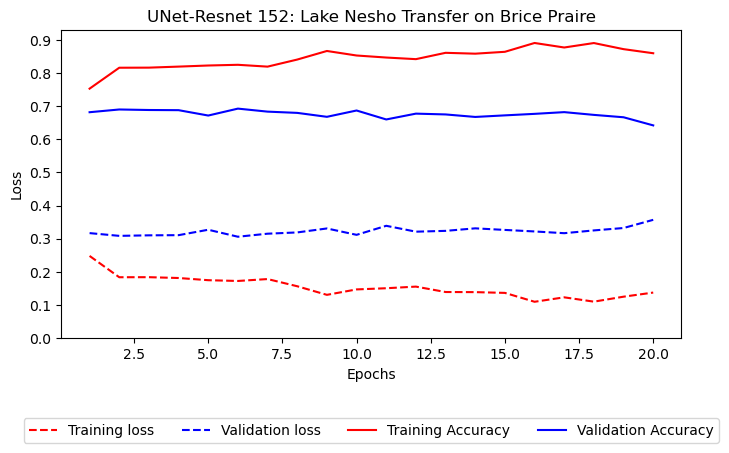

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))


loss = history_bp1_TL2.history['loss']
val_loss =  history_bp1_TL2.history['val_loss']
acc =  history_bp1_TL2.history['f1-score']
val_acc =  history_bp1_TL2.history['val_f1-score']
epochs = range(1, len(loss) + 1)
ax.plot(epochs, loss, '--', color='red', label='Training loss')
ax.plot(epochs, val_loss, '--', color='blue', label='Validation loss')
ax.plot(epochs, acc, 'r', label='Training Accuracy')
ax.plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax.set_title('UNet-Resnet 152: Lake Nesho Transfer on Brice Praire')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yticks(np.arange(0, 1, step=0.1))
ax.legend(bbox_to_anchor=(0.5, -0.3), loc="center", ncol=4)

In [35]:
new_model_train = new_model.evaluate(X_train, y_train_cat, batch_size = 64)
new_model_test = new_model.evaluate(X_test, y_test_cat, batch_size = 64)


6/6 [==============================] - 1s 236ms/step - loss: 0.2403 - f1-score: 0.7495


In [38]:
y_pred=new_model.predict(X_test)
pred_array=np.array(y_pred)
y_pred_argmax=np.argmax(pred_array, axis=3)

12/12 [==============================] - 1s 122ms/step


1/1 [==============================] - 0s 30ms/step


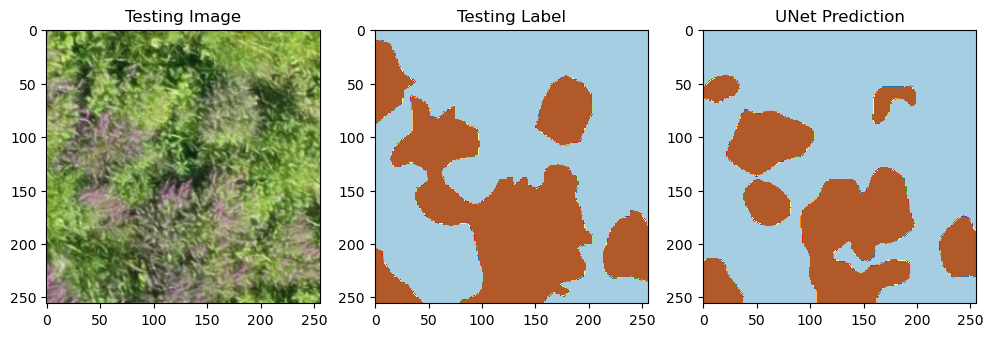

In [53]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

ground_truth=y_test[test_img_number]
ground_truth_array=np.array(ground_truth)

test_pred = new_model.predict(test_img_input)
test_pred_array=np.array(test_pred)
test_pred_array = np.squeeze(test_pred, 0)
test_prediction = np.argmax(test_pred_array, axis=2)[:, :]

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))

ax1.set_title('Testing Image')
ax1.imshow(test_img[:,:,], cmap='gray')

ax2.set_title('Testing Label')
ax2.imshow(ground_truth_array, cmap='Paired')

ax3.set_title('UNet Prediction')
ax3.imshow(test_prediction, cmap='Paired')

plt.show()